In [1]:
import time
from typing import Dict, List
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import os
import requests

[] Using tag: Revenues
[Gross Profit] No data for tags: ['GrossProfit']
[Cost (for GP derivation)] Using tag: CostOfGoodsAndServicesSold
[Gross Profit] Derived from Revenue – Cost
[] Using tag: NetIncomeLoss
      fy  fp        end       revenue  gross_profit  net_income  \
0   2020  Q3 2020-06-28  4.222100e+09           NaN  -678400000   
1   2021  Q1 2020-12-27  6.749400e+09           NaN   622200000   
2   2021  Q2 2021-03-28  6.668000e+09           NaN   659400000   
3   2021  Q3 2021-06-27  7.496500e+09           NaN  1153400000   
4   2022  Q1 2022-01-02  8.050400e+09           NaN   815900000   
5   2022  Q2 2022-04-03  7.635600e+09           NaN   674500000   
6   2022  Q3 2022-07-03  8.150100e+09           NaN   912900000   
7   2023  Q1 2023-01-01  8.713900e+09           NaN   855200000   
8   2023  Q2 2023-04-02  8.719800e+09           NaN   908300000   
9   2023  Q3 2023-07-02  9.168300e+09           NaN  1141700000   
10  2024  Q1 2023-12-31  9.425300e+09           NaN  10

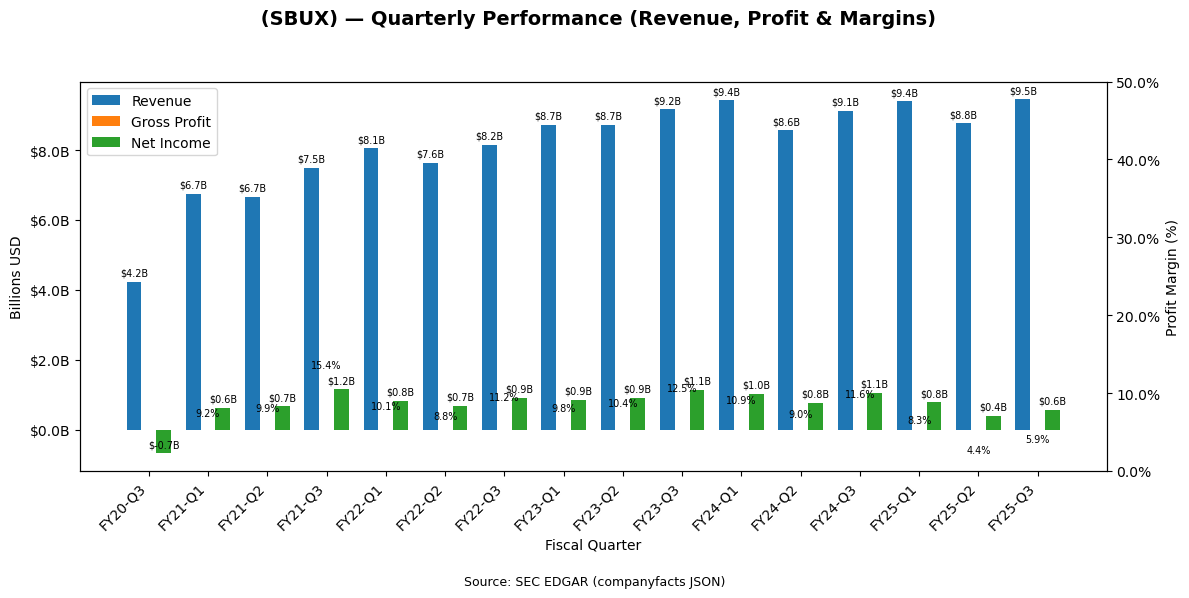

In [2]:
# --- Robust SEC EDGAR quarterly chart (handles missing GrossProfit) ---


# ---------- CONFIG ----------
UA = {"User-Agent": "Giulia Petrilli giuliapetrilli2000@gmail.com"}
BASE = "https://data.sec.gov/api"

# Tag candidates (in priority order)
REVENUE_TAGS = [
    "RevenueFromContractWithCustomerExcludingAssessedTax",  # ASC-606 "sales"
    "Revenues",
    "SalesRevenueNet"
]
GROSS_PROFIT_TAGS = ["GrossProfit"]  # may be absent
COST_TAGS = [
    "CostOfRevenue",
    "CostOfGoodsAndServicesSold"  # fallback name some filers use
]
NET_INCOME_TAGS = ["NetIncomeLoss"]

# ---------- UTIL / FETCH ----------
def load_ticker_map() -> Dict[str, str]:
    url = "https://www.sec.gov/files/company_tickers.json"
    r = requests.get(url, headers=UA, timeout=30)
    r.raise_for_status()
    j = r.json()
    return {v["ticker"].upper(): f'{int(v["cik_str"]):010d}' for v in j.values()}

def _get_json(url: str):
    r = requests.get(url, headers=UA, timeout=30)
    # handle 404 cleanly—means filer didn't use that tag
    if r.status_code == 404:
        return None
    r.raise_for_status()
    return r.json()

def company_concept(cik10: str, taxonomy: str, tag: str):
    url = f"{BASE}/xbrl/companyconcept/CIK{cik10}/{taxonomy}/{tag}.json"
    return _get_json(url)

def concept_to_df(j: dict, prefer_units=("USD", "USD$", "USD (in millions)")) -> pd.DataFrame:
    if j is None:
        return pd.DataFrame(columns=["fy","fp","end","val"])
    units = j.get("units", {})
    unit_key = None
    for u in prefer_units:
        if u in units:
            unit_key = u
            break
    if unit_key is None and units:
        unit_key = next(iter(units))
    rows = units.get(unit_key, [])
    if not rows:
        return pd.DataFrame(columns=["fy","fp","end","val"])
    df = pd.DataFrame(rows)
    for c in ("fy","fp","end","val"):
        if c not in df.columns: df[c] = pd.NA
    df["fy"] = pd.to_numeric(df["fy"], errors="coerce").astype("Int64")
    df["end"] = pd.to_datetime(df["end"], errors="coerce")
    return df.sort_values(["end","fy"], na_position="last").reset_index(drop=True)[["fy","fp","end","val"]]

def quarterly_series(df: pd.DataFrame) -> pd.DataFrame:
    q = df[df["fp"].str.upper().str.startswith("Q")].copy()
    if q.empty:
        return pd.DataFrame(columns=["fy","fp","end","value"])
    q["qnum"] = q["fp"].str.upper().str.extract(r"Q(\d)").astype("Int64")
    q = (q.sort_values("end")
           .groupby(["fy","qnum"], dropna=True)
           .agg(value=("val","last"), end=("end","last"))
           .reset_index())
    q["fp"] = "Q" + q["qnum"].astype("Int64").astype(str)
    return q[["fy","fp","end","value"]].sort_values(["fy","fp"])

def _fetch_first_available(cik10: str, tags: List[str], label: str = "") -> pd.DataFrame:
    """Try tags in order; return the first non-empty DF and print what was used."""
    for tag in tags:
        j = company_concept(cik10, "us-gaap", tag)
        if j is None:
            continue
        df = concept_to_df(j)
        if not df.empty:
            print(f"[{label}] Using tag: {tag}")
            return df
        time.sleep(0.2)
    print(f"[{label}] No data for tags: {tags}")
    return pd.DataFrame(columns=["fy","fp","end","val"])


def get_quarterly_financials(ticker: str, last_n_quarters: int = 16) -> pd.DataFrame:
    """
    Quarterly Revenue, Gross Profit (tag or derived), Net Income.
    """
    tmap = load_ticker_map()
    tk = ticker.upper()
    if tk not in tmap:
        raise ValueError(f"Ticker {ticker} not in SEC mapping.")
    cik10 = tmap[tk]

    # Revenue
    rev_df = _fetch_first_available(cik10, REVENUE_TAGS)
    rev_q = quarterly_series(rev_df).rename(columns={"value":"revenue"})

    time.sleep(0.2)

# Revenue

    # Gross Profit
    gp_df = _fetch_first_available(cik10, GROSS_PROFIT_TAGS, label="Gross Profit")
    gp_q  = quarterly_series(gp_df).rename(columns={"value":"gross_profit"})
    if gp_q.empty:
        cost_df = _fetch_first_available(cik10, COST_TAGS, label="Cost (for GP derivation)")
        cost_q  = quarterly_series(cost_df).rename(columns={"value":"cost"})
        gp_q = rev_q.merge(cost_q, on=["fy","fp","end"], how="left")
        gp_q["gross_profit"] = gp_q["revenue"] - gp_q["cost"]
        gp_q = gp_q[["fy","fp","end","gross_profit"]]
        print("[Gross Profit] Derived from Revenue – Cost")


    time.sleep(0.2)

    # Net Income
    ni_df = _fetch_first_available(cik10, NET_INCOME_TAGS)
    ni_q  = quarterly_series(ni_df).rename(columns={"value":"net_income"})

    # Combine
    df = rev_q.merge(gp_q, on=["fy","fp","end"], how="outer") \
              .merge(ni_q, on=["fy","fp","end"], how="outer") \
              .sort_values("end").reset_index(drop=True)

    df["gross_margin_pct"] = df["gross_profit"] / df["revenue"]
    df["net_margin_pct"]   = df["net_income"]  / df["revenue"]

    if last_n_quarters:
        df = df.tail(last_n_quarters).reset_index(drop=True)
    return df

# ---------- FORMATTING ----------
def _fmt_billions(x, pos):
    if np.isnan(x): return ""
    return f"${x/1e9:,.1f}B"

def _fmt_pct(x, pos):
    if np.isnan(x): return ""
    return f"{x*100:.1f}%"

# ---------- PLOTTING ----------
def plot_quarterly_performance(qdf: pd.DataFrame, company_name: str, ticker: str,
                               save_path: str = None):
    labels = [f"FY{str(int(fy))[-2:]}-{fp}" for fy, fp in zip(qdf["fy"], qdf["fp"])]
    x = np.arange(len(labels))
    width = 0.25

    fig, ax1 = plt.subplots(figsize=(12, 6))

    b1 = ax1.bar(x - width, qdf["revenue"], width, label="Revenue")
    b2 = ax1.bar(x,          qdf["gross_profit"], width, label="Gross Profit")
    b3 = ax1.bar(x + width,  qdf["net_income"], width, label="Net Income")

    ax1.set_ylabel("Billions USD")
    ax1.set_xlabel("Fiscal Quarter")
    ax1.set_xticks(x, labels, rotation=45, ha="right")
    ax1.yaxis.set_major_formatter(FuncFormatter(_fmt_billions))

    def _annotate(bars):
        for r in bars:
            h = r.get_height()
            if np.isnan(h): continue
            ax1.annotate(f"${h/1e9:,.1f}B",
                         xy=(r.get_x() + r.get_width()/2, h),
                         xytext=(0, 3),
                         textcoords="offset points",
                         ha="center", va="bottom", fontsize=7)
    _annotate(b1); _annotate(b2); _annotate(b3)

    ax2 = ax1.twinx()
    #l1, = ax2.plot(x, qdf["gross_margin_pct"], marker="o", label="Gross Margin %")
    #l2, = ax2.plot(x, qdf["net_margin_pct"], marker="o", label="Net Margin %")
    ax2.set_ylabel("Profit Margin (%)")
    ax2.yaxis.set_major_formatter(FuncFormatter(_fmt_pct))
    ycap = float(np.nanmax(qdf[["gross_margin_pct","net_margin_pct"]].values)) if not qdf.empty else 0.7
    ax2.set_ylim(0, max(0.5, ycap*1.2))

    for xi, yv in enumerate(qdf["gross_margin_pct"]):
        if pd.notna(yv):
            ax2.annotate(f"{yv*100:.1f}%", (x[xi], yv), textcoords="offset points",
                         xytext=(0, 6), ha="center", fontsize=7)
    for xi, yv in enumerate(qdf["net_margin_pct"]):
        if pd.notna(yv):
            ax2.annotate(f"{yv*100:.1f}%", (x[xi], yv), textcoords="offset points",
                         xytext=(0, -12), ha="center", fontsize=7)

    #handles = [b1, b2, b3, l1, l2]
    handles = [b1, b2, b3]
    labels = [h.get_label() for h in handles]
    ax1.legend(handles, labels, loc="upper left")

    fig.suptitle(f"{company_name} ({ticker.upper()}) — Quarterly Performance (Revenue, Profit & Margins)",
                 fontsize=14, fontweight="bold")
    fig.text(0.5, 0.02, "Source: SEC EDGAR (companyfacts JSON)", ha="center", fontsize=9)

    fig.tight_layout(rect=[0, 0.05, 1, 0.95])

    if save_path:
        fig.savefig(save_path, dpi=180, bbox_inches="tight")
    plt.show()

# ---------- EXAMPLE ----------
if __name__ == "__main__":
    TICKER = "SBUX"                 # e.g., "MCD", "KO", "QSR"
    COMPANY_NAME = ""
    SAVE_TO = None                 # e.g., "mcd_quarterly.png"

    qdf = get_quarterly_financials(TICKER, last_n_quarters=16)
    print(qdf)
    plot_quarterly_performance(qdf, COMPANY_NAME, TICKER, save_path=SAVE_TO)


      fy  fp        end   net_income
0   2016  Q1 2015-12-26  18361000000
1   2016  Q2 2016-03-26  28877000000
2   2016  Q3 2016-06-25   7796000000
3   2017  Q1 2016-12-31  17891000000
4   2017  Q2 2017-04-01  11029000000
5   2017  Q3 2017-07-01   8717000000
6   2018  Q1 2017-12-30  20065000000
7   2018  Q2 2018-03-31  33887000000
8   2018  Q3 2018-06-30  11519000000
9   2019  Q1 2018-12-29  19965000000
10  2019  Q2 2019-03-30  11561000000
11  2019  Q3 2019-06-29  10044000000
12  2020  Q1 2019-12-28  22236000000
13  2020  Q2 2020-03-28  33485000000
14  2020  Q3 2020-06-27  11253000000
15  2021  Q1 2020-12-26  28755000000
16  2021  Q2 2021-03-27  52385000000
17  2021  Q3 2021-06-26  21744000000
18  2022  Q1 2021-12-25  34630000000
19  2022  Q2 2022-03-26  25010000000
20  2022  Q3 2022-06-25  19442000000
21  2023  Q1 2022-12-31  29998000000
22  2023  Q2 2023-04-01  54158000000
23  2023  Q3 2023-07-01  19881000000
24  2024  Q1 2023-12-30  33916000000
25  2024  Q2 2024-03-30  57552000000
2

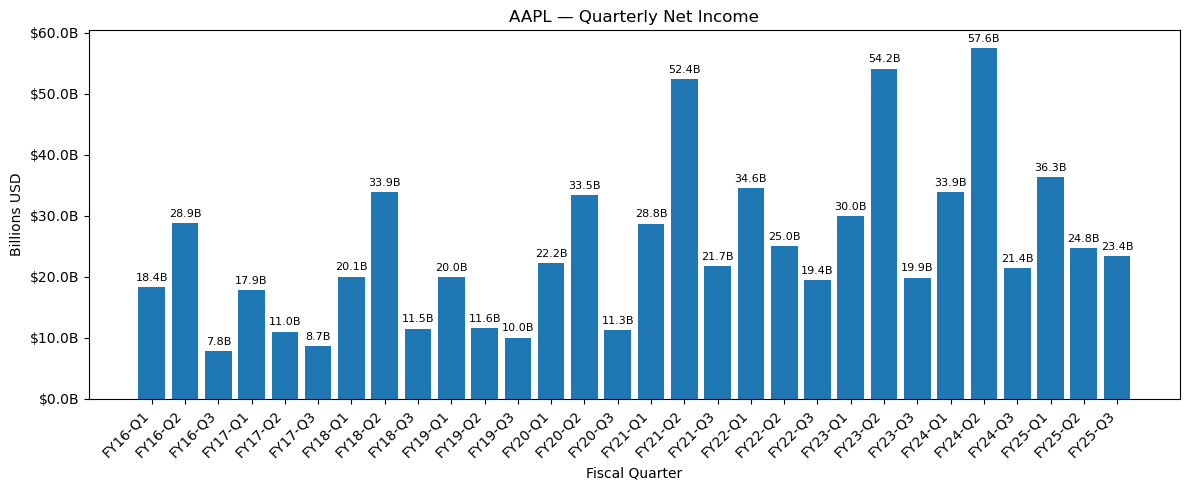

In [3]:
# --- Minimal SEC EDGAR quarterly revenue plot ---

UA = {"User-Agent": "Giulia Petrilli giuliapetrilli2000@gmail.com"}
BASE = "https://data.sec.gov/api"
NET_INCOME_TAG = "NetIncomeLoss"

def _get_json(url: str):
    r = requests.get(url, headers=UA, timeout=30)
    if r.status_code == 404:
        return None
    r.raise_for_status()
    return r.json()

def load_ticker_map() -> dict:
    url = "https://www.sec.gov/files/company_tickers.json"
    r = requests.get(url, headers=UA, timeout=30)
    r.raise_for_status()
    j = r.json()
    return {v["ticker"].upper(): f'{int(v["cik_str"]):010d}' for v in j.values()}

def company_concept(cik10: str, taxonomy: str, tag: str):
    return _get_json(f"{BASE}/xbrl/companyconcept/CIK{cik10}/{taxonomy}/{tag}.json")

def concept_to_df(j: dict, prefer_units=("USD","USD$","USD (in millions)")) -> pd.DataFrame:
    if not j:
        return pd.DataFrame(columns=["fy","fp","end","val"])
    units = j.get("units", {})
    unit_key = next((u for u in prefer_units if u in units), next(iter(units), None))
    rows = units.get(unit_key, [])
    if not rows:
        return pd.DataFrame(columns=["fy","fp","end","val"])
    df = pd.DataFrame(rows)
    for c in ("fy","fp","end","val"):
        if c not in df.columns: df[c] = pd.NA
    df["fy"] = pd.to_numeric(df["fy"], errors="coerce").astype("Int64")
    df["end"] = pd.to_datetime(df["end"], errors="coerce")
    return df.sort_values(["end","fy"], na_position="last").reset_index(drop=True)[["fy","fp","end","val"]]

def quarterly_series(df: pd.DataFrame, value_name="value") -> pd.DataFrame:
    q = df[df["fp"].astype(str).str.upper().str.startswith("Q")].copy()
    if q.empty:
        return pd.DataFrame(columns=["fy","fp","end",value_name])
    q["qnum"] = q["fp"].str.upper().str.extract(r"Q(\d)").astype("Int64")
    q = (q.sort_values("end")
           .groupby(["fy","qnum"], dropna=True)
           .agg(val=("val","last"), end=("end","last"))
           .reset_index())
    q["fp"] = "Q" + q["qnum"].astype("Int64").astype(str)
    q = q.rename(columns={"val": value_name})
    return q[["fy","fp","end",value_name]].sort_values(["fy","fp"])

def get_quarterly_net_income(ticker: str, last_n_quarters: int = 16) -> pd.DataFrame:
    tmap = load_ticker_map()
    tk = ticker.upper()
    if tk not in tmap:
        raise ValueError(f"Ticker {ticker} not found in SEC mapping.")
    cik10 = tmap[tk]
    ni_json = company_concept(cik10, "us-gaap", NET_INCOME_TAG)
    ni_q = quarterly_series(concept_to_df(ni_json), value_name="net_income")
    if last_n_quarters:
        ni_q = ni_q.tail(last_n_quarters).reset_index(drop=True)
    return ni_q

def _fmt_billions(x, pos):
    if np.isnan(x): return ""
    return f"${x/1e9:,.1f}B"

def plot_quarterly_net_income(ni_df: pd.DataFrame, ticker: str, save_path: str = None):
    if ni_df.empty:
        raise ValueError("No quarterly Net Income data available to plot.")
    labels = [f"FY{str(int(fy))[-2:]}-{fp}" for fy, fp in zip(ni_df["fy"], ni_df["fp"])]
    x = np.arange(len(labels))
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.bar(x, ni_df["net_income"])
    ax.set_title(f"{ticker.upper()} — Quarterly Net Income")
    ax.set_ylabel("Billions USD")
    ax.set_xlabel("Fiscal Quarter")
    ax.set_xticks(x, labels, rotation=45, ha="right")
    ax.yaxis.set_major_formatter(FuncFormatter(_fmt_billions))
    for rect in ax.patches:
        h = rect.get_height()
        if np.isnan(h): continue
        ax.annotate(f"{h/1e9:,.1f}B", (rect.get_x()+rect.get_width()/2, h),
                    xytext=(0, 3), textcoords="offset points",
                    ha="center", va="bottom", fontsize=8)
    fig.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=180, bbox_inches="tight")
    plt.show()

# ---- Example ----
if __name__ == "__main__":
    TICKER = "AAPL"
    df = get_quarterly_net_income(TICKER, last_n_quarters=30)
    print(df)
    plot_quarterly_net_income(df, TICKER)


In [4]:
import time
from typing import Dict, List
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# ---------- CONFIG ----------
UA = {"User-Agent": "Giulia Petrilli giuliapetrilli2000@gmail.com"}
BASE = "https://data.sec.gov/api"

# --- TAG GROUPS ---
REVENUE_TAGS = [
    "RevenueFromContractWithCustomerExcludingAssessedTax",
    "Revenues",
    "SalesRevenueNet"
]
GROSS_PROFIT_TAGS = ["GrossProfit"]
COST_TAGS = ["CostOfRevenue", "CostOfGoodsAndServicesSold"]
NET_INCOME_TAGS = ["NetIncomeLoss"]

OPERATING_EXP_TAGS = ["OperatingExpenses", "SellingGeneralAndAdministrativeExpenses"]
R_AND_D_TAGS = ["ResearchAndDevelopmentExpense"]
DEPR_AMORT_TAGS = ["DepreciationAndAmortization", "AmortizationExpense"]
INTEREST_EXP_TAGS = ["InterestExpense"]
INTEREST_INC_TAGS = ["InterestIncome"]
INCOMEBEFORETAX_TAGS = ["IncomeBeforeTax"]
TAX_TAGS = ["IncomeTaxExpenseBenefit", "ProvisionForIncomeTaxes"]

EPS_BASIC_TAGS = ["EarningsPerShareBasic"]
EPS_DILUTED_TAGS = ["EarningsPerShareDiluted"]
SHARES_BASIC_TAGS = ["WeightedAverageNumberOfSharesOutstandingBasic"]
SHARES_DILUTED_TAGS = ["WeightedAverageNumberOfDilutedSharesOutstanding"]

ASSETS_TAGS = ["Assets"]
ASSETS_CURR_TAGS = ["AssetsCurrent"]
LIAB_TAGS = ["Liabilities"]
LIAB_CURR_TAGS = ["LiabilitiesCurrent"]
EQUITY_TAGS = ["StockholdersEquity", "Equity"]
CASH_TAGS = ["CashAndCashEquivalentsAtCarryingValue"]
RECEIVABLES_TAGS = ["AccountsReceivableNetCurrent"]
INVENTORY_TAGS = ["InventoriesNet"]
DEBT_TAGS = ["LongTermDebt"]

CAPEX_TAGS = ["CapitalExpenditures"]
OPER_CASHFLOW_TAGS = ["NetCashProvidedByOperatingActivities"]
INV_CASHFLOW_TAGS = ["NetCashUsedForInvestingActivities"]
FIN_CASHFLOW_TAGS = ["NetCashProvidedByFinancingActivities"]

EMPLOYEE_TAGS = ["NumberOfEmployees", "WeightedAverageNumberOfEmployees"]

# ---------- UTIL / FETCH ----------
def load_ticker_map() -> Dict[str, str]:
    url = "https://www.sec.gov/files/company_tickers.json"
    r = requests.get(url, headers=UA, timeout=30)
    r.raise_for_status()
    j = r.json()
    return {v["ticker"].upper(): f'{int(v["cik_str"]):010d}' for v in j.values()}

def _get_json(url: str):
    r = requests.get(url, headers=UA, timeout=30)
    if r.status_code == 404:
        return None
    r.raise_for_status()
    return r.json()

def company_concept(cik10: str, taxonomy: str, tag: str):
    url = f"{BASE}/xbrl/companyconcept/CIK{cik10}/{taxonomy}/{tag}.json"
    return _get_json(url)

def concept_to_df(j: dict, prefer_units=("USD", "USD$", "USD (in millions)")) -> pd.DataFrame:
    if j is None:
        return pd.DataFrame(columns=["fy","fp","end","val"])
    units = j.get("units", {})
    unit_key = None
    for u in prefer_units:
        if u in units:
            unit_key = u
            break
    if unit_key is None and units:
        unit_key = next(iter(units))
    rows = units.get(unit_key, [])
    if not rows:
        return pd.DataFrame(columns=["fy","fp","end","val"])
    df = pd.DataFrame(rows)
    for c in ("fy","fp","end","val"):
        if c not in df.columns: df[c] = pd.NA
    df["fy"] = pd.to_numeric(df["fy"], errors="coerce").astype("Int64")
    df["end"] = pd.to_datetime(df["end"], errors="coerce")
    return df.sort_values(["end","fy"], na_position="last").reset_index(drop=True)[["fy","fp","end","val"]]

def quarterly_series(df: pd.DataFrame) -> pd.DataFrame:
    q = df[df["fp"].str.upper().str.startswith("Q")].copy()
    if q.empty:
        return pd.DataFrame(columns=["fy","fp","end","value"])
    q["qnum"] = q["fp"].str.upper().str.extract(r"Q(\d)").astype("Int64")
    q = (q.sort_values("end")
           .groupby(["fy","qnum"], dropna=True)
           .agg(value=("val","last"), end=("end","last"))
           .reset_index())
    q["fp"] = "Q" + q["qnum"].astype("Int64").astype(str)
    return q[["fy","fp","end","value"]].sort_values(["fy","fp"])

def _fetch_first_available(cik10: str, tags: List[str], label: str = "") -> pd.DataFrame:
    for tag in tags:
        j = company_concept(cik10, "us-gaap", tag)
        if j is None:
            continue
        df = concept_to_df(j)
        if not df.empty:
            print(f"[{label}] Using tag: {tag}")
            return df
        time.sleep(0.2)
    print(f"[{label}] No data for tags: {tags}")
    return pd.DataFrame(columns=["fy","fp","end","val"])

# ---------- MAIN FUNCTION ----------
def get_quarterly_financials(ticker: str, last_n_quarters: int = 16) -> pd.DataFrame:
    tmap = load_ticker_map()
    tk = ticker.upper()
    if tk not in tmap:
        raise ValueError(f"Ticker {ticker} not in SEC mapping.")
    cik10 = tmap[tk]

    def _add_column(df, tags, colname, label=""):
        q = quarterly_series(_fetch_first_available(cik10, tags, label=label))
        return q.rename(columns={"value": colname})

    # Core
    rev_q = _add_column(None, REVENUE_TAGS, "revenue", "Revenue")
    gp_q  = _add_column(None, GROSS_PROFIT_TAGS, "gross_profit", "Gross Profit")
    if gp_q.empty:
        cost_q = _add_column(None, COST_TAGS, "cost", "Cost (for GP derivation)")
        gp_q = rev_q.merge(cost_q, on=["fy","fp","end"], how="left")
        gp_q["gross_profit"] = gp_q["revenue"] - gp_q["cost"]
        gp_q = gp_q[["fy","fp","end","gross_profit"]]
        print("[Gross Profit] Derived from Revenue – Cost")

    ni_q = _add_column(None, NET_INCOME_TAGS, "net_income", "Net Income")

    # Expanded metrics
    op_exp_q   = _add_column(None, OPERATING_EXP_TAGS, "operating_expenses", "Operating Exp")
    rnd_q      = _add_column(None, R_AND_D_TAGS, "r_and_d", "R&D")
    da_q       = _add_column(None, DEPR_AMORT_TAGS, "depr_amort", "D&A")
    int_exp_q  = _add_column(None, INTEREST_EXP_TAGS, "interest_expense", "Interest Exp")
    int_inc_q  = _add_column(None, INTEREST_INC_TAGS, "interest_income", "Interest Inc")
    ebt_q      = _add_column(None, INCOMEBEFORETAX_TAGS, "income_before_tax", "Income Before Tax")
    tax_q      = _add_column(None, TAX_TAGS, "tax_expense", "Tax Expense")

    eps_b_q    = _add_column(None, EPS_BASIC_TAGS, "eps_basic", "EPS Basic")
    eps_d_q    = _add_column(None, EPS_DILUTED_TAGS, "eps_diluted", "EPS Diluted")
    sh_b_q     = _add_column(None, SHARES_BASIC_TAGS, "shares_basic", "Shares Basic")
    sh_d_q     = _add_column(None, SHARES_DILUTED_TAGS, "shares_diluted", "Shares Diluted")

    assets_q   = _add_column(None, ASSETS_TAGS, "assets", "Assets")
    assets_c_q = _add_column(None, ASSETS_CURR_TAGS, "assets_current", "Assets Current")
    liab_q     = _add_column(None, LIAB_TAGS, "liabilities", "Liabilities")
    liab_c_q   = _add_column(None, LIAB_CURR_TAGS, "liabilities_current", "Liabilities Current")
    equity_q   = _add_column(None, EQUITY_TAGS, "equity", "Equity")
    cash_q     = _add_column(None, CASH_TAGS, "cash", "Cash")
    ar_q       = _add_column(None, RECEIVABLES_TAGS, "accounts_receivable", "AR")
    inv_q      = _add_column(None, INVENTORY_TAGS, "inventory", "Inventory")
    debt_q     = _add_column(None, DEBT_TAGS, "long_term_debt", "Debt")

    capex_q    = _add_column(None, CAPEX_TAGS, "capex", "CapEx")
    ocf_q      = _add_column(None, OPER_CASHFLOW_TAGS, "operating_cf", "Op Cash Flow")
    icf_q      = _add_column(None, INV_CASHFLOW_TAGS, "investing_cf", "Inv Cash Flow")
    fcf_q      = _add_column(None, FIN_CASHFLOW_TAGS, "financing_cf", "Fin Cash Flow")

    emp_q      = _add_column(None, EMPLOYEE_TAGS, "employees", "Employees")

    # Merge all
    dfs = [
        rev_q, gp_q, ni_q, op_exp_q, rnd_q, da_q, int_exp_q, int_inc_q,
        ebt_q, tax_q, eps_b_q, eps_d_q, sh_b_q, sh_d_q,
        assets_q, assets_c_q, liab_q, liab_c_q, equity_q,
        cash_q, ar_q, inv_q, debt_q,
        capex_q, ocf_q, icf_q, fcf_q,
        emp_q
    ]
    df = dfs[0]
    for d in dfs[1:]:
        df = df.merge(d, on=["fy","fp","end"], how="outer")

    # Margins
    df["gross_margin_pct"] = df["gross_profit"] / df["revenue"]
    df["net_margin_pct"]   = df["net_income"]  / df["revenue"]

    if last_n_quarters:
        df = df.sort_values("end").tail(last_n_quarters).reset_index(drop=True)
    return df


In [5]:
# check if the df gets generated
if __name__ == "__main__":
    TICKER = "CMG"  # replace with any ticker
    df = get_quarterly_financials(TICKER, last_n_quarters=16)

    print(df)

    # Show all columns and shape
    print(df.columns)
    print(df.shape)

[Revenue] Using tag: Revenues
[Gross Profit] No data for tags: ['GrossProfit']
[Cost (for GP derivation)] No data for tags: ['CostOfRevenue', 'CostOfGoodsAndServicesSold']
[Gross Profit] Derived from Revenue – Cost
[Net Income] Using tag: NetIncomeLoss
[Operating Exp] No data for tags: ['OperatingExpenses', 'SellingGeneralAndAdministrativeExpenses']
[R&D] No data for tags: ['ResearchAndDevelopmentExpense']
[D&A] No data for tags: ['DepreciationAndAmortization', 'AmortizationExpense']
[Interest Exp] No data for tags: ['InterestExpense']
[Interest Inc] No data for tags: ['InterestIncome']
[Income Before Tax] No data for tags: ['IncomeBeforeTax']
[Tax Expense] Using tag: IncomeTaxExpenseBenefit
[EPS Basic] Using tag: EarningsPerShareBasic
[EPS Diluted] Using tag: EarningsPerShareDiluted
[Shares Basic] Using tag: WeightedAverageNumberOfSharesOutstandingBasic
[Shares Diluted] Using tag: WeightedAverageNumberOfDilutedSharesOutstanding
[Assets] Using tag: Assets
[Assets Current] Using tag: As

In [6]:
# save in folders 

if __name__ == "__main__":
    boycotted = False # set to False for control group
    TICKER = "CMG"  # replace with any ticker
    df = get_quarterly_financials(TICKER, last_n_quarters=16)

    print(df)

    df.insert(0, 'ticker', TICKER.upper())

    if boycotted:
        df.insert(0, 'boycotted', 1)
    else:
        df.insert(0, 'boycotted', 0)

    # Choose folder based on boycotted flag
    base_path = "/Users/giuliamariapetrilli/Documents/GitHub/masters_thesis/data"
    if boycotted:
        folder = f"{base_path}/boycott_target/{TICKER.lower()}"
    else:
        folder = f"{base_path}/control_group/{TICKER.lower()}"

    # Create folder if it doesn’t exist
    os.makedirs(folder, exist_ok=True)

    # Save the file
    output_path = f"{folder}/{TICKER.lower()}_quarterly.csv"
    df.to_csv(output_path, index=False)

    # Show all columns and shape
    print(df.columns)
    print(df.shape)

    print(f"✅ File saved to: {output_path}")


[Revenue] Using tag: Revenues
[Gross Profit] No data for tags: ['GrossProfit']
[Cost (for GP derivation)] No data for tags: ['CostOfRevenue', 'CostOfGoodsAndServicesSold']
[Gross Profit] Derived from Revenue – Cost
[Net Income] Using tag: NetIncomeLoss
[Operating Exp] No data for tags: ['OperatingExpenses', 'SellingGeneralAndAdministrativeExpenses']
[R&D] No data for tags: ['ResearchAndDevelopmentExpense']
[D&A] No data for tags: ['DepreciationAndAmortization', 'AmortizationExpense']
[Interest Exp] No data for tags: ['InterestExpense']
[Interest Inc] No data for tags: ['InterestIncome']
[Income Before Tax] No data for tags: ['IncomeBeforeTax']
[Tax Expense] Using tag: IncomeTaxExpenseBenefit
[EPS Basic] Using tag: EarningsPerShareBasic
[EPS Diluted] Using tag: EarningsPerShareDiluted
[Shares Basic] Using tag: WeightedAverageNumberOfSharesOutstandingBasic
[Shares Diluted] Using tag: WeightedAverageNumberOfDilutedSharesOutstanding
[Assets] Using tag: Assets
[Assets Current] Using tag: As